In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as st

from datetime import datetime

# Loading data

In [44]:
num_runs = 17
data_all = []
path = "14May23/"
for i in range(1, 17+1):
    if i < 10:
        data_all.append(pd.read_csv(path + f"data0{i}.csv"))
    else:
        data_all.append(pd.read_csv(path + f"data{i}.csv"))

    # Convert time to miliseconds
    data_all[-1]["time_ms"] = data_all[-1]["now"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f').timestamp() * 1000)
    data_all[-1]["time_ms"] = data_all[-1]["time_ms"].apply(lambda x: x - data_all[-1]["time_ms"].iloc[0])

    # Remove outliers
    data_all[-1] = data_all[-1][data_all[-1].intensity > 0.65]

stat_data = data_all[16-1]
cw_data = data_all[15-1]
ccw_data = data_all[12-1]

In [46]:
# Append headers (comment out if headers already added)
header = "now,intensity,humidity,temperature,temperature_from_humidity,temperature_from_pressure,pressure,orientation_roll,orientation_pitch,orientation_yaw,compass,compass_raw_x,compass_raw_y,compass_raw_z,gyro_roll,gyro_pitch,gyro_yaw,gyro_raw_x,gyro_raw_y,gyro_raw_z,accelerometer_raw_x,accelerometer_raw_y,accelerometer_raw_z\n"

def append_headers(i_start, i_end):
    for i in range(i_start, i_end):
        if i < 10:
            f = open(f"data0{i}.csv", "r+")
        else:
            f = open(f"data{i}.csv", "r+")
        content = f.read()
        f.seek(0, 0)
        f.write(header + content)
        f.close()

# append_headers(1, 17+1)



# Plotting $I(\Omega(t))$

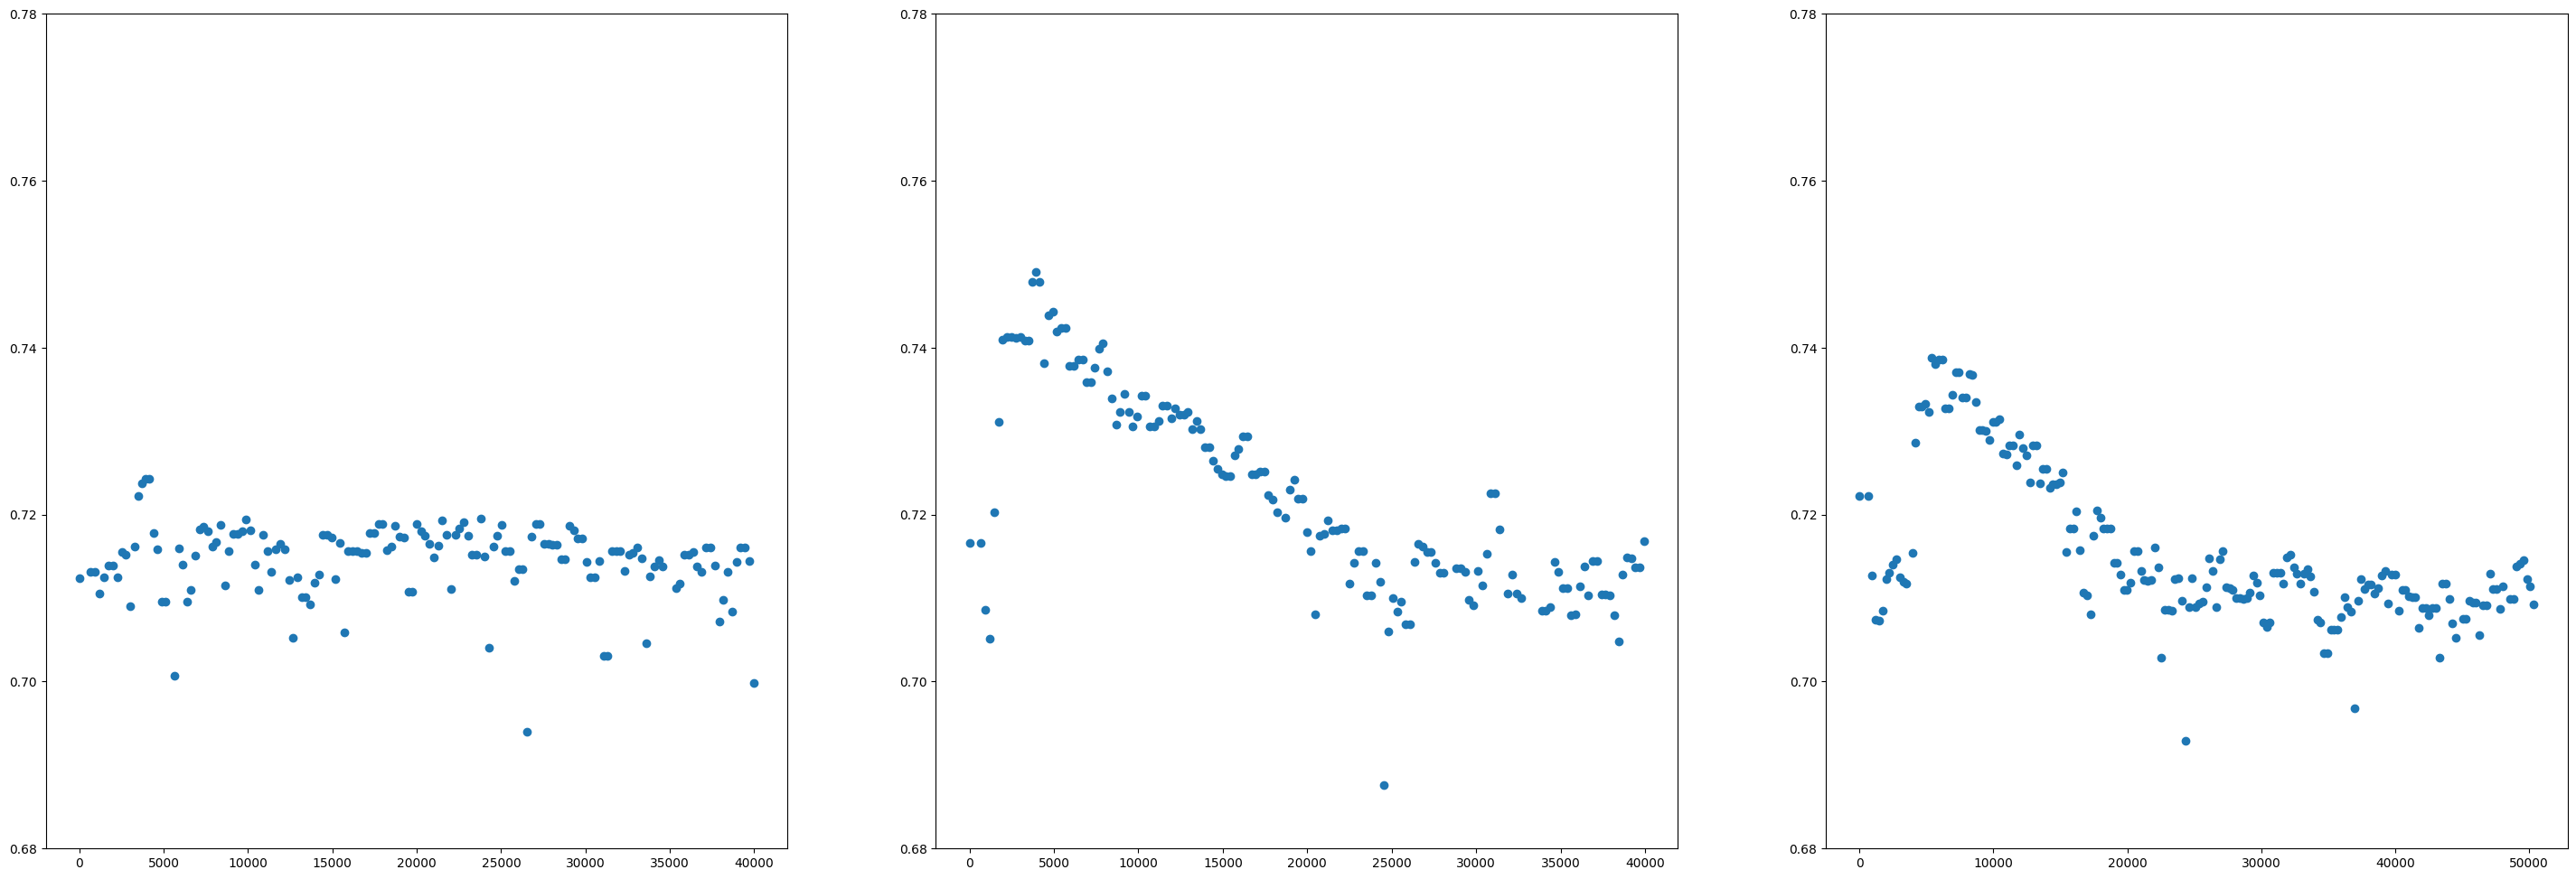

In [47]:
fig, ax = plt.subplots(1, 3, figsize=(36, 12))

for i in range(3):
    ax[i].set_ylim([0.68, 0.78])

ax[0].scatter(stat_data["time_ms"], stat_data["intensity"])
ax[1].scatter(cw_data["time_ms"], cw_data["intensity"])
ax[2].scatter(ccw_data["time_ms"], ccw_data["intensity"])

plt.show()

# Plotting true $\Omega(t)$

In [48]:
# a.k.a we plotting d(yaw)/dt
# Take the derivative

for i in range(num_runs):
    data_all[i]["yaw_rad"] = data_all[i]["gyro_yaw"].apply(np.deg2rad)
    data_all[i]["yaw_rad"] = np.unwrap(data_all[i]["yaw_rad"])

    data_all[i]["dt"] = data_all[i]["time_ms"].diff()
    data_all[i]["dYaw"] = data_all[i]["yaw_rad"].diff()

    data_all[i]["Omega"] = data_all[i]["dYaw"] / data_all[i]["dt"]

stat_data = data_all[16-1]
cw_data = data_all[15-1]
ccw_data = data_all[12-1]

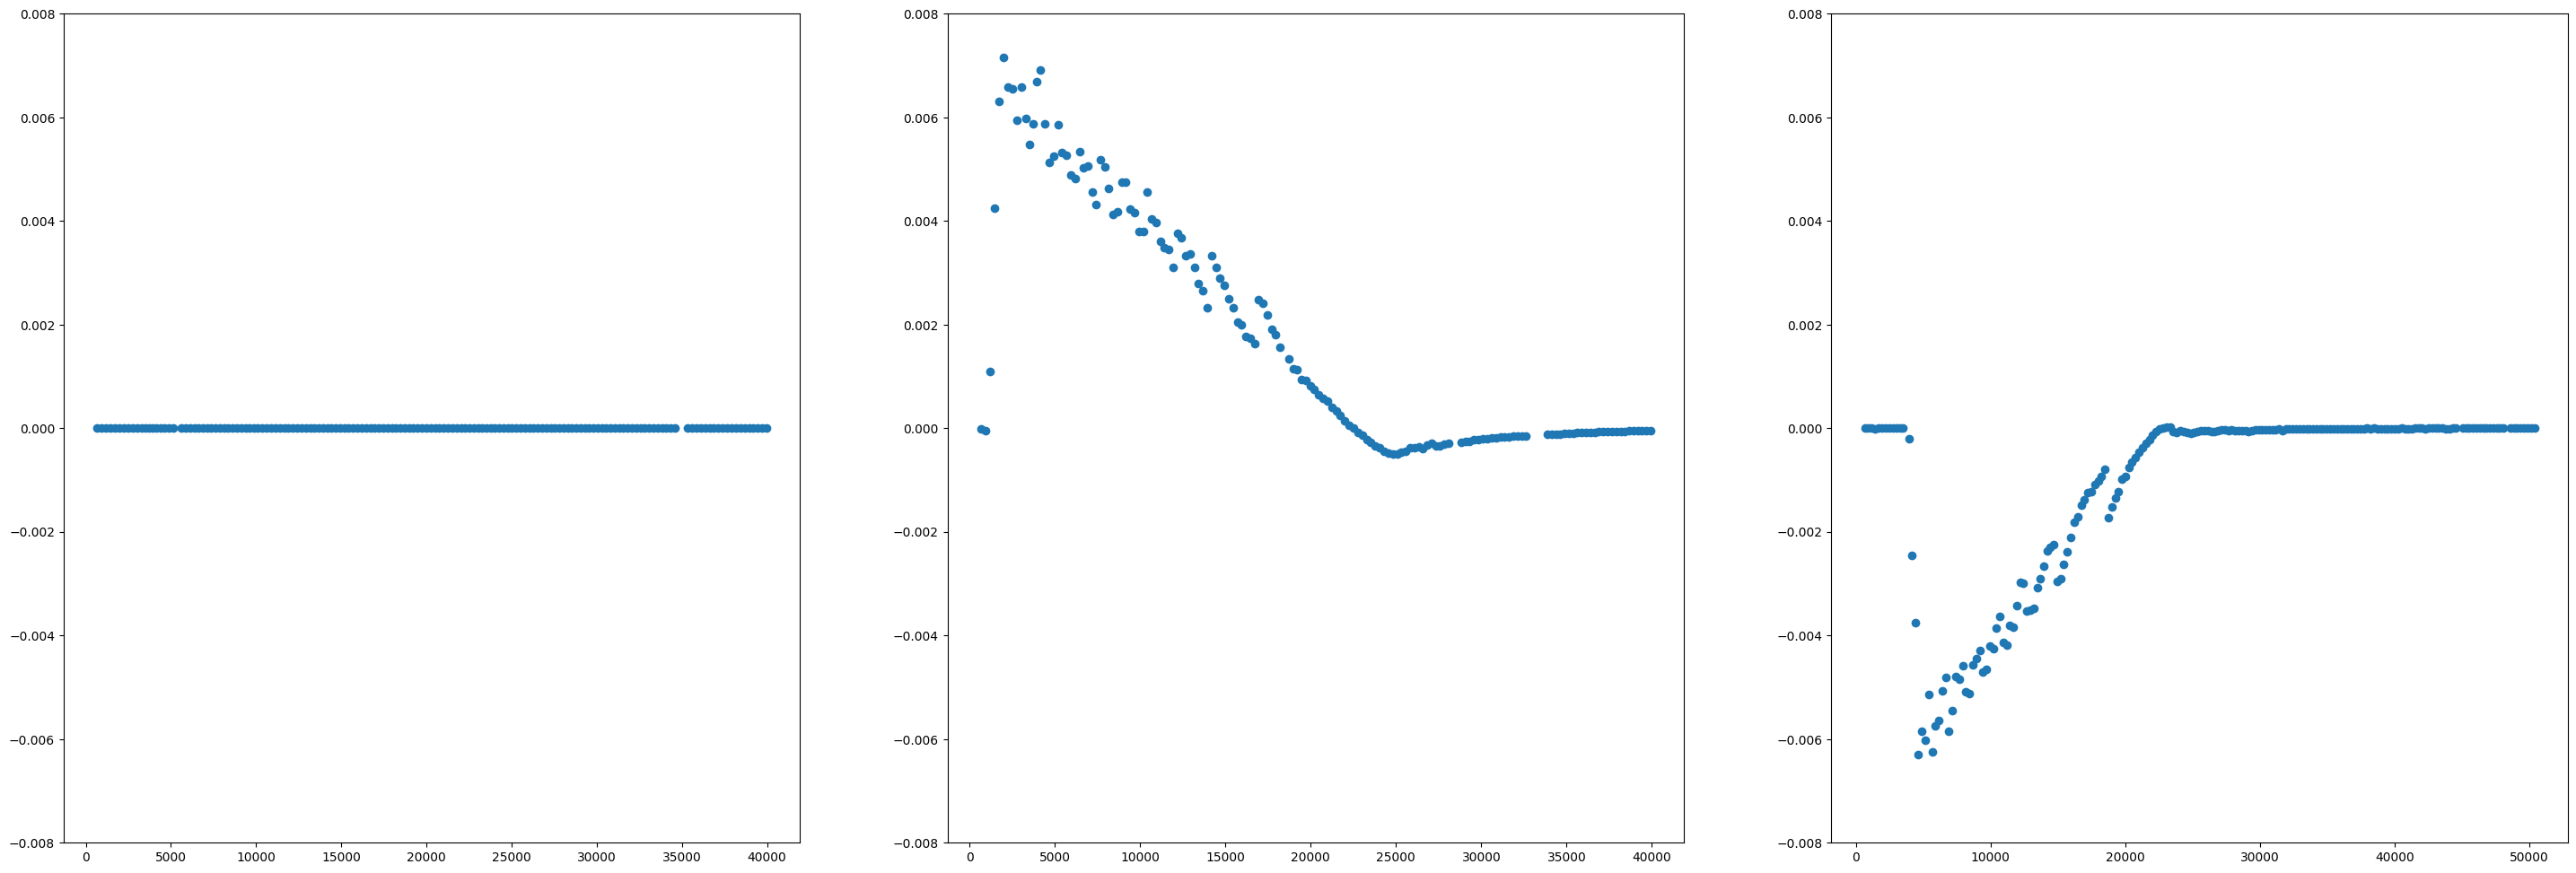

In [49]:
# the actual plotting

fig, ax = plt.subplots(1, 3, figsize=(36, 12))

for i in range(3):
    ax[i].set_ylim([-0.008, 0.008])

ax[0].scatter(stat_data["time_ms"], stat_data["Omega"])
ax[1].scatter(cw_data["time_ms"], cw_data["Omega"])
ax[2].scatter(ccw_data["time_ms"], ccw_data["Omega"])

plt.show()